In [1]:
#: the usual imports
import babypandas as bpd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Lecture 12

### A/B Testing

## Today's lecture

- So far, we've been assessing models given a single random sample.
    - We flip a coin 400 times. Are the flips consistent with the coin being fair?
    - Did the jury panel in the Swain case look like a random sample from the eligible population?
    - Are the test scores for the GSI's section a random sample from the class's scores?
- But we often have *two* random samples we wish to compare.
    - Outcomes of patients assigned to control group and treatment group in a pharmaceutical study.
    - Number of clicks from people who saw version A of an advertisement vs. version B
- **A/B testing**: decide whether two random samples come from the same distribution.
- The "exciting" outcome is typically that which *rejects* the null hypothesis.

# Example 1: Birth Weight and Smoking

## Smoking and birth weight

- Is there a significant difference in the weight of babies born to mothers who smoke, vs. non-smokers?
- Observational study, two groups:
    - babies whose mothers smoke
    - babies whose mothers do not smoke

In [3]:
#: our data
baby = bpd.read_csv('data/babby.csv')
baby

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


In [4]:
#: we only need "Birth Weight" and "Maternal Smoker"
smoking_and_birthweight = baby.get(['Maternal Smoker', 'Birth Weight'])
smoking_and_birthweight

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136
...,...,...
1169,False,113
1170,False,128
1171,True,130
1172,False,125


## First, some exploratory analysis

In [5]:
# how many are in each group?
smoking_and_birthweight.groupby('Maternal Smoker').count()

,Birth Weight
Maternal Smoker,
False,715
True,459


In [6]:
# what is the average weight within each group?
smoking_and_birthweight.groupby('Maternal Smoker').mean()

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


## Visualizing the distribution of each group

In [7]:
smokers = smoking_and_birthweight[smoking_and_birthweight.get('Maternal Smoker')]
non_smokers = smoking_and_birthweight[smoking_and_birthweight.get('Maternal Smoker') == False]

Text(0.5, 0, 'Birth Weight')

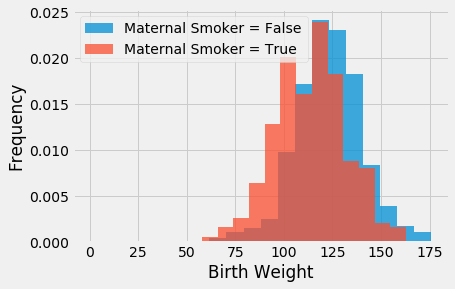

In [8]:
fig, ax = plt.subplots()
non_smokers.plot(kind='hist', density=True, ax=ax, alpha=.75, bins=20)
smokers.plot(kind='hist', density=True, ax=ax, alpha=.75, bins=20)
plt.legend(['Maternal Smoker = False', 'Maternal Smoker = True'])
plt.xlabel('Birth Weight')

## The question...

<img src="./data/smoker-hists.png"/>

- Does the difference we see reflect a real difference in the population?
- Or is it just due to random chance?

## Testing the hypotheses

- **Null hypothesis**: In the population, birth weights of smokers and non-smokers have the same distribution.
    - I.e., what we saw is due to random chance.
- **Alternative hypothesis**: In the population, babies born to smokers typically have lower birth weight.

## Discussion question

What is a reasonable statistic to compute in order to test these hypotheses?

- A) The difference in the size of each group.
- B) The difference between the mean birth weight of each group.
- C) The TVD (Total Variation Distance) between the group distributions.
- D) The standard deviation.

## Answer: difference between means

In [23]:
means_table = smoking_and_birthweight.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [24]:
#: difference between them
means = means_table.get('Birth Weight')
observed_difference = means.loc[True] - means.loc[False]
observed_difference

-9.266142572024918

## Testing through simulation

- **Statistic**: Difference between means.
- **Null hypothesis**: The two groups are sampled from the same distribution.
- Note that the null hypothesis doesn't say *what* the distribution is.
    - Different from jury panel example, fair coin example, etc.
    - We can't draw directly from the distribution!
- We have to do something a bit more clever.

## Implications of the null hypothesis

- Under the null hypothesis, both groups are sampled from the same distribution.
- If true, then `Maternal Smoker` has no relationship with `Birth Weight`.
- If we were to shuffle the columns independently, the data is just as likely.

In [25]:
smoking_and_birthweight.iloc[:5]

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


## Permutation tests

- Perhaps the difference in means we saw is due to random chance in assignment.
- **Permutation test**: Shuffle the group labels a bunch of times; how often do we see a statistic this extreme?
- Randomly permuting labels is equivalent to randomly assigning birth weights to groups (without changing group sizes)
- If we *rarely* see something this extreme, then the null hypothesis doesn't look likely.

## Permutation tests with tables

- We want to randomly shuffle the `Maternal Smoker` column.
- `np.random.permutation` takes in an array, returns a shuffled version

In [26]:
data = bpd.DataFrame().assign(x=['a', 'b', 'c'], y=[1, 2, 3])
data

,x,y
0,a,1
1,b,2
2,c,3


In [27]:
np.random.permutation(data.get('y'))

array([1, 2, 3])

In [28]:
data.assign(shuffled_y=np.random.permutation(data.get('y')))

,x,y,shuffled_y
0,a,1,3
1,b,2,2
2,c,3,1


## Discussion Question

In the birthweight example, we want to shuffle only one column. For the purpose of permutation testing, 
does it matter which column we shuffle -- the `Maternal Smoker` column or the `Birth Weight` column?

- A) Yes
- B) No

## Shuffling the groups

In [29]:
# it doesn't matter which column we shuffle, but it will be more convenient to shuffle weights
original_and_shuffled = smoking_and_birthweight.assign(
    ShuffledBirthWeight=np.random.permutation(smoking_and_birthweight.get('Birth Weight'))
)
original_and_shuffled

,Maternal Smoker,Birth Weight,ShuffledBirthWeight
0,False,120,92
1,False,113,102
2,True,128,122
3,True,108,121
4,False,136,130
...,...,...,...
1169,False,113,122
1170,False,128,127
1171,True,130,107
1172,False,125,122


## How close are the means of the shuffled groups?

In [30]:
#: shuffling the weights makes it easier to do this...
original_and_shuffled.groupby('Maternal Smoker').mean()

,Birth Weight,ShuffledBirthWeight
Maternal Smoker,,
False,123.085315,119.260140
True,113.819172,119.777778


Text(0.5, 0, 'Birth Weight')

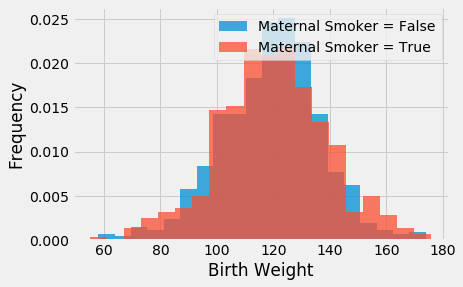

In [31]:
fig, ax = plt.subplots()
smokers = original_and_shuffled[original_and_shuffled.get('Maternal Smoker')]
non_smokers = original_and_shuffled[original_and_shuffled.get('Maternal Smoker') == False]
non_smokers.plot(kind='hist', y='ShuffledBirthWeight', density=True, ax=ax, alpha=.75, bins=20)
smokers.plot(kind='hist',y='ShuffledBirthWeight', density=True, ax=ax, alpha=.75, bins=20)
plt.legend(['Maternal Smoker = False', 'Maternal Smoker = True'])
plt.xlabel('Birth Weight')

## Simulation

- This was just one random shuffle.
- How likely is it that a random shuffle results in a 9+ ounce difference in means?
- We have to repeat the shuffling a bunch of times. On each iteration:
    1. Shuffle the weights.
    2. Put them in a table.
    3. Compute difference in group means.

In [32]:
n_repetitions = 500

differences = np.array([])
for i in np.arange(n_repetitions):
    # 1) shuffle the weights
    shuffled_weights = np.random.permutation(
        smoking_and_birthweight.get('Birth Weight')
    )
    
    # 2) put them in a table
    shuffled = smoking_and_birthweight.assign(
        ShuffledBirthWeight=shuffled_weights
    )
    
    # 3) compute the group differences
    group_means = (
        shuffled
        .groupby('Maternal Smoker').mean()
        .get('ShuffledBirthWeight')
    )
    difference = group_means.loc[True] - group_means.loc[False]
    
    # add it to our array storing the results
    differences = np.append(differences, difference)

## Conclusion of the test

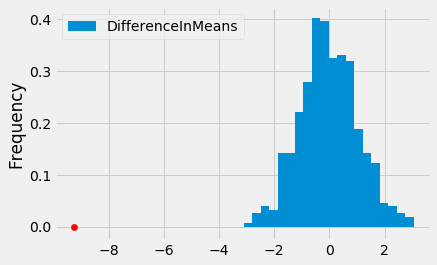

In [33]:
bpd.DataFrame().assign(DifferenceInMeans=differences).plot(kind='hist', bins=20, density=True)
plt.scatter(observed_difference, 0, color='red', s=40)

## Conclusion

- Under the null hypothesis, we rarely see differences as large as this.
- Therefore, we reject the null hypothesis: the two groups do not come from the same distribution.

## Caution!

- We **cannot** conclude that smoking *causes* lower birth weight!
- This was an observational study; there may be confounding factors.
    - Maybe smokers are more likely to drink caffeine, and caffeine causes lower birth weight.
- But it suggests that it is worth studying with a randomized controlled trial.

## A slightly different example

- Is there a difference in birthweight between babies born to:
    - Group A: Mothers over 25
    - Group B: Mothers 25 or under

In [34]:
over_25 = baby.get('Maternal Age') > 25
age_and_birthweight = baby.get(['Birth Weight']).assign(Over25=over_25)
age_and_birthweight

,Birth Weight,Over25
0,120,True
1,113,True
2,128,True
3,108,False
4,136,False
...,...,...
1169,113,True
1170,128,False
1171,130,True
1172,125,False


In [35]:
#: the group means
group_means = age_and_birthweight.groupby('Over25').mean()
group_means

,Birth Weight
Over25,
False,118.495183
True,120.229008


In [36]:
#: the difference between them
means = group_means.get('Birth Weight')
observed_difference = means.loc[False] - means.loc[True]
observed_difference

-1.7338245892717907

## The permutation test

- **Null hypothesis**: Birth weights for both groups come from the same distribution.
- **Alternative hypothesis**: No, mothers below 25 have heavier babies.
- We run a permutation test with the difference in means as the statistic.

## Simulation

In [37]:
#: similar code to before

np.random.seed(424242)
n_repetitions = 500

differences = np.array([])
for i in np.arange(n_repetitions):
    # 1) shuffle the weights
    shuffled_weights = np.random.permutation(
        age_and_birthweight.get('Birth Weight')
    )
    
    # 2) put them in a table
    shuffled = age_and_birthweight.assign(
        ShuffledBirthWeight=shuffled_weights
    )
    
    # 3) compute the group differences
    group_means = (
        shuffled
        .groupby('Over25').mean()
        .get('ShuffledBirthWeight')
    )
    difference = group_means.loc[True] - group_means.loc[False]
    
    # add it to our array storing the results
    differences = np.append(differences, difference)

## Conclusion of the test

- Do we reject the null hypothesis?
- What can we compute to tell us the degree of uncertainty here?

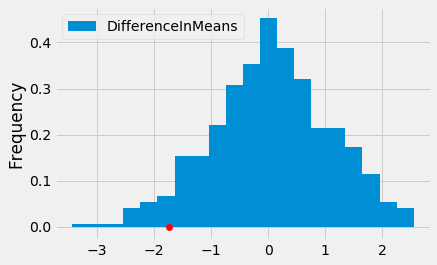

In [38]:
bpd.DataFrame().assign(DifferenceInMeans=differences).plot(kind='hist', bins=20, density=True)
plt.scatter(observed_difference, 0, color='red', s=40, zorder=10)

## The p-value

- The probability of seeing a difference of means $\leq$ the observed, under the null hypothesis.

In [39]:
np.count_nonzero(differences <= observed_difference) / n_repetitions

0.042

# Example 2: Deflategate

## Did the New England Patriots cheat?

<img width="40%" src="./data/deflate.jpg">

- On January 18, 2015, the Patriots played the Indianapolis Colts for a spot in the Super Bowl
- The Patriots won, 45 -- 7. They went on to win the Super Bowl
- After the game, it was alleged that the Patriots intentionally deflated footballs (making them easier to catch)

## Background

- Each team brings 12 footballs to the game.
- NFL rules stipulate: each ball must be inflated to between 12.5 and 13.5 pounds per square inch (psi).
- Before the game, officials found that all of the Patriot's footballs were at about 12.5 psi, all of the Colts were about 13.0 psi.
- In the second quarter, Colts intercepted a Patriots ball and notified officials that it felt under-inflated.
- At halftime, two officials (Blakeman and Prioleau) each measured the pressure again.
- They ran out of time, and couldn't measure the pressure of all of the footballs.

## The measurements

In [41]:
#: all of the measurements
footballs = bpd.read_csv('./data/deflategate.csv')
footballs

,Team,Blakeman,Prioleau
0,Patriots,11.50,11.80
1,Patriots,10.85,11.20
2,Patriots,11.15,11.50
3,Patriots,10.70,11.00
4,Patriots,11.10,11.45
...,...,...,...
10,Patriots,10.90,11.35
11,Colts,12.70,12.35
12,Colts,12.75,12.30
13,Colts,12.50,12.95


## Combining the measurements

- Both officials measured each ball.
- Their measurements are slightly different.
- We average them to get a combined weight.

In [42]:
#: a combined measurement
footballs = footballs.assign(
    Combined=(footballs.get('Blakeman') + footballs.get('Prioleau')) / 2
)
footballs

,Team,Blakeman,Prioleau,Combined
0,Patriots,11.50,11.80,11.650
1,Patriots,10.85,11.20,11.025
2,Patriots,11.15,11.50,11.325
3,Patriots,10.70,11.00,10.850
4,Patriots,11.10,11.45,11.275
...,...,...,...,...
10,Patriots,10.90,11.35,11.125
11,Colts,12.70,12.35,12.525
12,Colts,12.75,12.30,12.525
13,Colts,12.50,12.95,12.725


## Differences in average pressure

- At first glance, it looks as though the Patriots footballs are at a lower pressure.
- We could do a permutation test for difference in mean pressure.
- But that wouldn't point towards cheating.
    - The Patriot's balls *started* at a lower psi.
- The allegations were that the Patriots *deflated* the balls.
    - We want to check to see if the Patriots balls lost more pressure than the Colts'.

In [43]:
#:: group means
footballs.groupby('Team').mean()

,Blakeman,Prioleau,Combined
Team,,,
Colts,12.625000,12.437500,12.531250
Patriots,11.109091,11.486364,11.297727


## Calculating the pressure drop

- We therefore calculate the drop in pressure for each ball.
- Patriots' started at 12.5 psi, Colts' started at 13.
- We make an array with starting pressure for each ball.
- Handy function: `np.where(array_of_true_and_false, true_value, false_value)`.
    - Replaces `True` in the array with `true_value`, and `False` with `false_value`.

In [44]:
#...starting_pressure
starting_pressure = np.where(
    footballs.get('Team') == 'Patriots',
    12.5,
    13
)
starting_pressure

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

## Calculating the pressure drop

In [45]:
#: add the drop to the table
footballs = footballs.assign(
    PressureDrop=(starting_pressure - footballs.get('Combined'))
)
footballs

,Team,Blakeman,Prioleau,Combined,PressureDrop
0,Patriots,11.50,11.80,11.650,0.850
1,Patriots,10.85,11.20,11.025,1.475
2,Patriots,11.15,11.50,11.325,1.175
3,Patriots,10.70,11.00,10.850,1.650
4,Patriots,11.10,11.45,11.275,1.225
...,...,...,...,...,...
10,Patriots,10.90,11.35,11.125,1.375
11,Colts,12.70,12.35,12.525,0.475
12,Colts,12.75,12.30,12.525,0.475
13,Colts,12.50,12.95,12.725,0.275


## The question

- Did the Patriots' footballs drop in pressure more than the Colts'?
- A/B test!
- **Null hypothesis**: The drop in pressures for both teams came from the same distribution.
    - By chance, the Patriots' footballs deflated more.
- **Alternative hypothesis**: No, the Patriots' footballs deflated more than one would expect due to random chance alone.

## The statistic

- Difference between teams' average pressure drops.

In [46]:
#: the group means
means = footballs.groupby('Team').mean().get('PressureDrop')
means

Team
Colts       0.468750
Patriots    1.202273
Name: PressureDrop, dtype: float64

In [47]:
#: the observed difference
observed_difference = means.loc['Patriots'] - means.loc['Colts']
observed_difference

0.733522727272728

- The average pressure drop for the Patriots was 0.73 psi more than the Colts.

## Permutation test

- We run a permutation test to see if this is a significant difference.
- Permute the drop in pressure (or the team column), many times.

In [48]:
#: run a permutation test
n_repetitions = 5000

# BEGIN SOLUTION
differences = np.array([])
for i in np.arange(n_repetitions):
    # shuffle the weights
    shuffled_drops = np.random.permutation(footballs.get('PressureDrop'))
    
    # put them in a table
    shuffled = footballs.assign(
        ShuffledPressureDrop=shuffled_drops
    )
    
    # compute the group differences
    group_means = (
        shuffled
        .groupby('Team').mean()
        .get('ShuffledPressureDrop')
    )
    difference = group_means.loc['Patriots'] - group_means.loc['Colts']
    
    # add it to our array storing results
    differences = np.append(differences, difference)
# END SOLUTION

## Conclusion

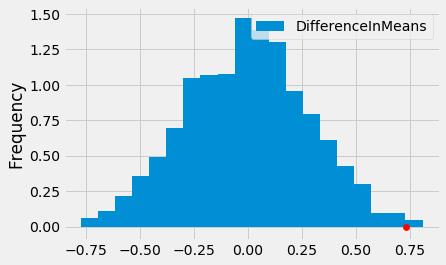

In [49]:
bpd.DataFrame().assign(DifferenceInMeans=differences).plot(kind='hist', bins=20, density=True)
plt.scatter(observed_difference, 0, color='red', s=40, zorder=10)

- It doesn't look good for the Patriots. What is the p-value?

In [50]:
#: p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

0.0036

## Caution!

- We conclude that it is unlikely that the difference in mean pressure drop is due to chance alone.
- But this doesn't establish *causation*.
- That is, did the Patriots *deliberately* deflate their footballs?
- This was an *observational* study; to establish causation, we need an RCT (Randomized Controlled Trial).

# Causality

## Recap

- We have used A/B testing to assess group differences.
- Example:
    - Study: Babies born to mothers who smoke typically weigh less.
    - Permutation test conclusion: this is unlikely to be due to random chance.
- Rejecting the null hypothesis **does not** establish causality.
    - Tempting to think that smoking causes lower birthweight.
    - But there could be **confounding factors**...
    - Maybe *caffeine* causes lower birthweight, and caffeine intake is correlated with smoking.

## Randomized Controlled Trial

- This was an **observational study**.
- We've seen that randomizing groups then applying "treatment" avoids confounding factors.
- This is known as a **Randomized Controlled Trial** (RCT).
- An A/B test in a RCT *does* support causality.

## Why?

- Suppose we want to examine the link between chocolate and heart health.
- We do an observational study and see that chocolate-eaters have healthier hearts.

In [52]:
bpd.read_csv('data/coffee_observational.csv').get(['Chocolate', 'Good Heart'])

,Chocolate,Good Heart
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1
5,0,0
6,0,0
7,0,1
8,0,0
9,0,0


- We want to say that eating chocolate *causes* good heart health.
- But it turns out that chocolate-eaters are more likely to consume caffeine.
- And suppose it is *caffeine* which actually helps heart health.

In [53]:
#: chocolate, caffeine, and heart health
bpd.read_csv('data/coffee_observational.csv')

,Chocolate,Good Heart,Caffeine
0,1,1,0
1,1,0,1
2,1,1,1
3,1,1,1
4,1,1,1
5,0,0,0
6,0,0,0
7,0,1,1
8,0,0,0
9,0,0,1


## Why?

- The chocolate-eating group had better health because it had more caffeine consumers.
- Now suppose we do an RCT and select random groups.
- *Then* we apply the treatment (chocolate).
- Randomization ensures that the caffeine consumers are (roughly) divided between the treatment and control group.
- The effect of the confounding factor is mitigated.

In [55]:
#: the rct results
bpd.read_csv('data/coffee_rct.csv')

,Caffeine,Chocolate,Good Heart
0,1,1,1
1,0,1,0
2,1,1,1
3,0,1,0
4,0,1,1
5,1,0,1
6,0,0,0
7,0,0,0
8,1,0,1
9,1,0,1


## Example: Chronic Back Pain

## Treatment with botulinum toxin

- Botulinum Toxin A is the "most acutely lethal toxin known" (Wikipedia).
    - About 100 *nanograms* injected intravenously is lethal to a human.
- Used for treating muscle disorders and for cosmetic reasons (Botox).
- A randomized controlled study examined the use of Botulinum Toxin A in the treatment of lower back pain.
    - 31 patients with pain were randomly assigned to control and treatment groups.
    - Control group received placebo (saline).
    - Treatment group received botulinism toxin.
    - After eight weeks, the number of people who experienced relief was counted.

## The data

In [57]:
#: 1 means "experienced relief", 0 means "no relief"
back = bpd.read_csv('./data/bta.csv')
back

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0
...,...,...
26,Treatment,0.0
27,Treatment,0.0
28,Treatment,0.0
29,Treatment,0.0


## The results

In [58]:
#: proportion experiencing relief
back.groupby('Group').mean()

,Result
Group,
Control,0.125
Treatment,0.600


- It looks like there was a clear benefit to treatment.
- Can this just be due to chance?

## An A/B test

- Group A = Control, Group B = Treatment
- **Null hypothesis**: Results for both groups come from the same distribution.
- **Test statistic**: difference in proportion experiencing relief.

In [59]:
#: proportion experiencing relief
relief = back.groupby('Group').mean()
relief

,Result
Group,
Control,0.125
Treatment,0.600


In [60]:
#: the observed group difference
reliefs = relief.get('Result')
observed_difference = reliefs.loc['Treatment'] - reliefs.loc['Control']
observed_difference

0.475

## The simulation

In [61]:
np.random.seed(4242)
#: run a permutation test
# BEGIN SOLUTION
n_repetitions = 500

differences = np.array([])

for i in np.arange(n_repetitions):
    # permute the results
    shuffled_results = np.random.permutation(back.get('Result'))
    
    shuffled = back.assign(ShuffledResult=shuffled_results)
    
    # compute the statistic
    relief = shuffled.groupby('Group').mean().get('ShuffledResult')
    difference = relief.loc['Treatment'] - relief.loc['Control']
    differences = np.append(differences, difference)
# END SOLUTION

## Conclusion

In [62]:
difference

-0.041666666666666685

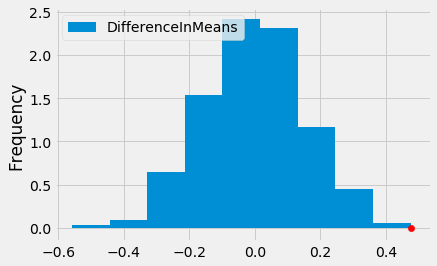

In [63]:
bpd.DataFrame().assign(DifferenceInMeans=differences).plot(kind='hist', bins=9, density=True)
plt.scatter(observed_difference, 0, color='red', s=40, zorder=10)

In [64]:
# BEGIN SOLUTION
np.count_nonzero(differences >= observed_difference) / n_repetitions
# END SOLUTION

0.006

## Conclusion

- We reject the null hypothesis with a high degree of confidence.
- This is evidence that the treatment *caused* improvement.
    - *Because* this was an *randomized controlled trial*.